# Data classification

# Features Selection with SHAP

## Step 1: Train an XGBoost model with all features


Starting analysis for C:\Users\lamia\Desktop\datasets\Dataset1_shift.csv
Loaded data from C:\Users\lamia\Desktop\datasets\Dataset1_shift.csv, shape: (105169, 44)
Model training completed.
Processing condition: oestrus
Processing condition: calving
Processing condition: mastitis
Processing condition: lameness
Processing condition: other_disease
Processing condition: ok


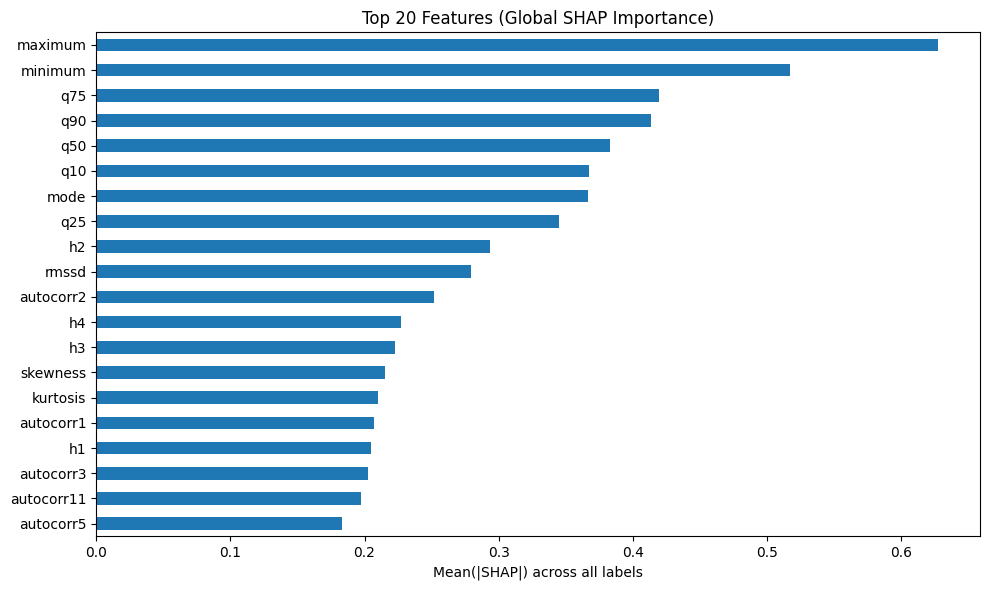


Top features by global SHAP importance:
             oestrus   calving  mastitis  lameness  other_disease        ok  mean_global
maximum     0.481148  0.532677  0.926933  0.745834       0.679017  0.398753     0.627394
minimum     0.231258  1.694808  0.181720  0.382448       0.392093  0.220822     0.517192
q75         0.387094  0.430710  0.420943  0.430143       0.498590  0.348242     0.419287
q90         0.384144  0.428232  0.560388  0.473257       0.405470  0.231400     0.413815
q50         0.245370  0.390043  0.299362  0.830513       0.355590  0.178650     0.383255
q10         0.240808  0.459349  0.321668  0.372189       0.567280  0.242054     0.367225
mode        0.316489  0.264708  0.604347  0.443191       0.355741  0.217102     0.366930
q25         0.170299  0.371914  0.449603  0.329322       0.518787  0.230494     0.345070
h2          0.206182  0.222725  0.647303  0.148403       0.398831  0.139336     0.293797
rmssd       0.156472  0.214058  0.307033  0.521461       0.279081  0.

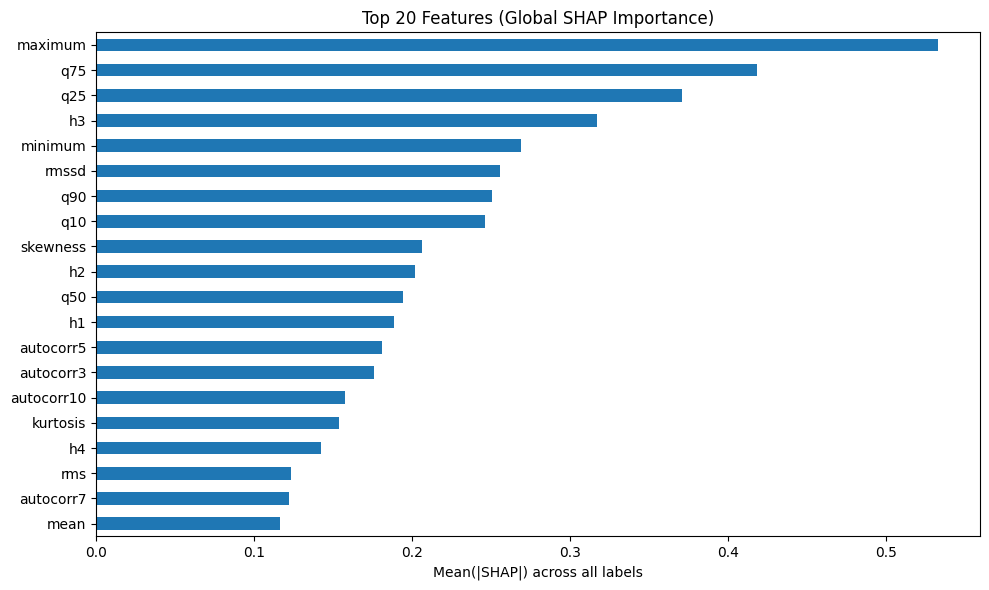


Top features by global SHAP importance:
             oestrus  mastitis  lameness  other_disease        ok  mean_global
maximum     0.988158  0.292298  0.574201            0.0  0.810320     0.532995
q75         0.789730  0.172383  0.538612            0.0  0.591797     0.418504
q25         0.229522  0.993846  0.329526            0.0  0.301950     0.370969
h3          0.217525  0.441812  0.606397            0.0  0.321558     0.317458
minimum     0.184425  0.502822  0.315826            0.0  0.340565     0.268728
rmssd       0.294882  0.000000  0.624495            0.0  0.359168     0.255709
q90         0.326976  0.261114  0.339467            0.0  0.326642     0.250840
q10         0.454670  0.000000  0.320081            0.0  0.455314     0.246013
skewness    0.391665  0.000000  0.307450            0.0  0.331410     0.206105
h2          0.313966  0.000000  0.397129            0.0  0.298915     0.202002
q50         0.350888  0.001454  0.279363            0.0  0.341192     0.194579
h1         

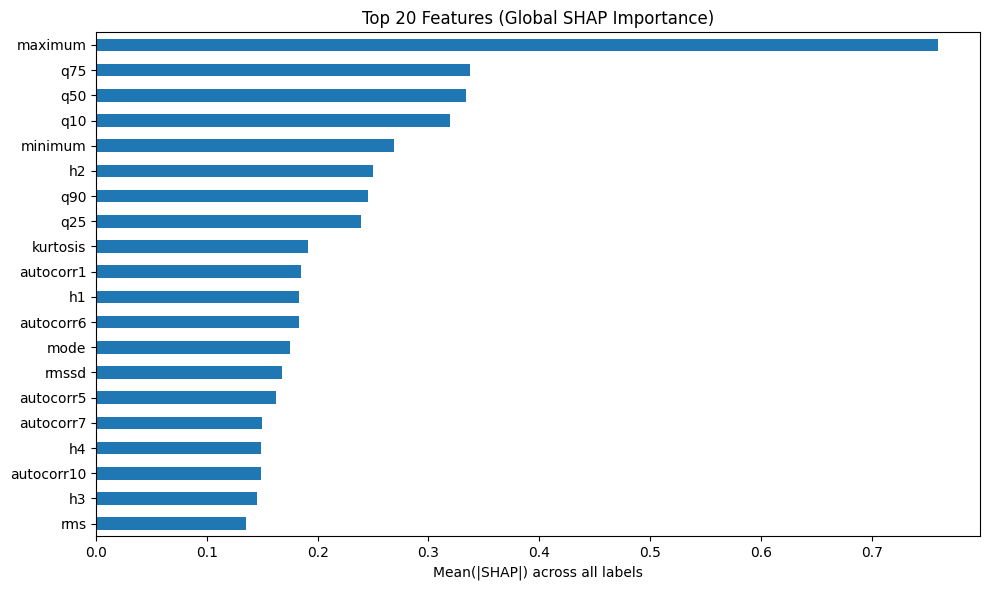


Top features by global SHAP importance:
             oestrus        ok  mean_global
maximum     0.759838  0.759838     0.759838
q75         0.337334  0.337334     0.337334
q50         0.333903  0.333903     0.333903
q10         0.319367  0.319367     0.319367
minimum     0.269299  0.269299     0.269299
h2          0.249729  0.249729     0.249729
q90         0.245856  0.245856     0.245856
q25         0.239483  0.239483     0.239483
kurtosis    0.191587  0.191587     0.191587
autocorr1   0.184716  0.184716     0.184716
h1          0.183568  0.183568     0.183568
autocorr6   0.183390  0.183390     0.183390
mode        0.175373  0.175373     0.175373
rmssd       0.167875  0.167875     0.167875
autocorr5   0.162812  0.162812     0.162812
autocorr7   0.149506  0.149506     0.149506
h4          0.149278  0.149278     0.149278
autocorr10  0.149129  0.149129     0.149129
h3          0.145349  0.145349     0.145349
rms         0.135654  0.135654     0.135654
✅ Threshold 0.050 | 29 features | F

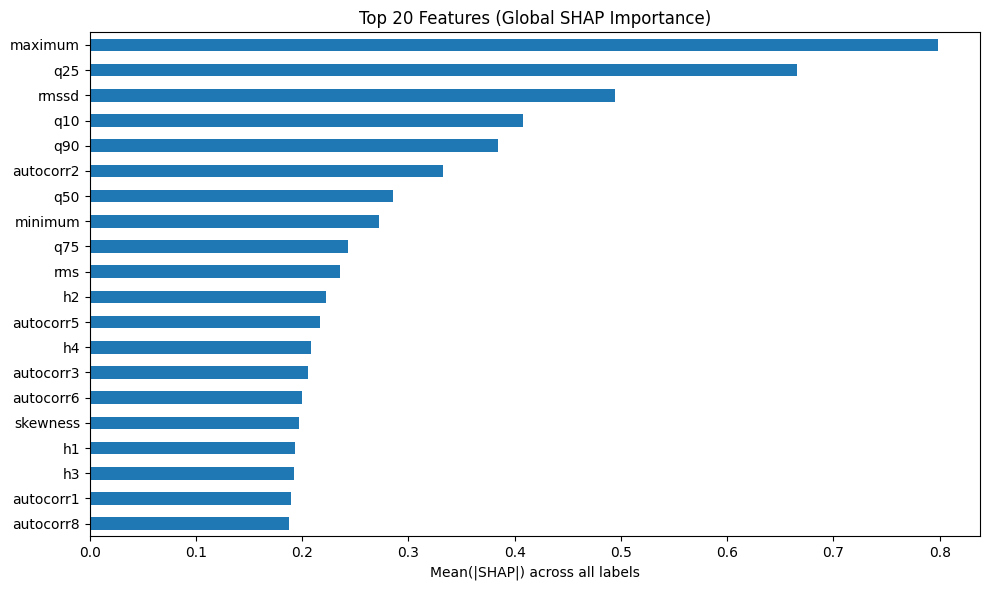


Top features by global SHAP importance:
            oestrus   calving  mastitis  lameness  other_disease        ok  mean_global
maximum    0.944434  0.645981  0.966888  0.779490       0.729119  0.722280     0.798032
q25        0.661024  0.970990  0.680964  0.520828       0.454844  0.703734     0.665397
rmssd      0.205171  0.508658  0.923618  0.295664       0.624644  0.409102     0.494476
q10        0.356706  0.739494  0.297973  0.442332       0.438154  0.171190     0.407642
q90        0.431635  0.148556  0.312215  0.458268       0.712862  0.242032     0.384261
autocorr2  0.189511  0.631887  0.213107  0.570614       0.222954  0.169302     0.332896
q50        0.372029  0.141100  0.468400  0.358933       0.183031  0.190613     0.285684
minimum    0.225573  0.249968  0.500905  0.224904       0.319718  0.111893     0.272160
q75        0.279191  0.160965  0.209329  0.299188       0.260821  0.251766     0.243544
rms        0.608531  0.161815  0.294345  0.148058       0.121659  0.078081     

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

def load_data(file_path, feature_cols, label_cols):
    """Load dataset and split into features and labels."""
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded data from {file_path}, shape: {df.shape}")
        
        # Lowercase column names to ensure consistency
        df.columns = df.columns.str.strip().str.lower()
        feature_cols_lower = [col.lower() for col in feature_cols]
        label_cols_lower = [col.lower() for col in label_cols]

        # Check for missing columns and handle them gracefully
        present_features = [col for col in feature_cols_lower if col in df.columns]
        present_labels = [col for col in label_cols_lower if col in df.columns]

        if not present_features:
            print("Error: No feature columns found in the dataset.")
            return None, None, None
        if not present_labels:
            print("Error: No label columns found in the dataset.")
            return None, None, None

        X = df[present_features]
        y = df[present_labels]
        return X, y, df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None, None, None
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None, None, None

def train_model(X_train, y_train):
    """Train a MultiOutputClassifier with XGBoost."""
    base_model = xgb.XGBClassifier(
        eval_metric='logloss',
        enable_categorical=False
    )
    multi_model = MultiOutputClassifier(base_model)
    multi_model.fit(X_train, y_train)
    print("Model training completed.")
    return multi_model

def compute_shap_values(multi_model, X_test, label_cols):
    """Compute SHAP values for each label and calculate mean global importance."""
    shap_matrix = pd.DataFrame(index=X_test.columns)

    for i, target in enumerate(label_cols):
        print(f"Processing condition: {target}")
        single_model = multi_model.estimators_[i]
        explainer = shap.Explainer(single_model)
        shap_values = explainer(X_test)
        mean_shap = np.abs(shap_values.values).mean(axis=0)
        shap_matrix[target] = mean_shap

    shap_matrix['mean_global'] = shap_matrix.mean(axis=1)
    return shap_matrix

def visualize_top_features(shap_matrix, n=20):
    """Visualize top N features by global SHAP importance."""
    shap_ranked = shap_matrix.sort_values('mean_global', ascending=False)
    top_features = shap_ranked.head(n)

    plt.figure(figsize=(10, 6))
    top_features['mean_global'].plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top {n} Features (Global SHAP Importance)")
    plt.xlabel("Mean(|SHAP|) across all labels")
    plt.tight_layout()
    plt.show()
    print("\nTop features by global SHAP importance:")
    print(top_features.to_string())
    return top_features

def evaluate_thresholds(X_train, X_test, y_train, y_test, shap_matrix, thresholds, label_cols):
    """Evaluate model performance across different SHAP thresholds."""
    results = []
    
    for threshold in thresholds:
        selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()
        
        if not selected_features:
            print(f"🔴 Threshold {threshold:.3f}: no features selected.")
            continue
            
        X_train_sel = X_train[selected_features]
        X_test_sel = X_test[selected_features]
        
        model_sel = MultiOutputClassifier(xgb.XGBClassifier(
            eval_metric='logloss',
            enable_categorical=False
        ))
        model_sel.fit(X_train_sel, y_train)
        y_pred = model_sel.predict(X_test_sel)
        
        # Multi-label evaluation
        f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])])
        precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])])
        recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])])
        try:
            y_prob = np.column_stack([model_sel.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y_test.shape[1])])
            auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y_test.shape[1])])
        except Exception as e:
            print(f"Warning: AUC calculation failed for threshold {threshold:.3f}: {str(e)}")
            auc = np.nan
        
        print(f"✅ Threshold {threshold:.3f} | {len(selected_features)} features | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")
        results.append({
            'threshold': threshold,
            'num_features': len(selected_features),
            'f1_macro': f1,
            'precision_macro': precision,
            'recall_macro': recall,
            'roc_auc_macro': auc
        })
    results_df = pd.DataFrame(results)
    print("\nPerformance evaluation for different SHAP thresholds:")
    print(results_df.sort_values(by='f1_macro', ascending=False).to_string())
    return results_df

def save_selected_features_dataset(df, selected_features, label_cols, output_path):
    """Save dataset with selected features and labels."""
    if not selected_features:
        print("No features selected for the given threshold.")
        return
    final_selected_df = df[[col.lower() for col in selected_features] + [col.lower() for col in label_cols]]
    try:
        final_selected_df.to_csv(output_path, index=False)
        print(f"Selected features dataset saved to '{output_path}'.")
        print("\nFirst 3 rows of the saved dataset:")
        print(final_selected_df.head(3).to_string())
    except Exception as e:
        print(f"Error saving to {output_path}: {str(e)}")

def run_shap_analysis(file_path, label_cols):
    """Main pipeline to run SHAP analysis on a single dataset."""
    print(f"\n{'='*50}\nStarting analysis for {file_path}\n{'='*50}")

    # Define feature columns (assuming they are consistent across datasets after pre-processing)
    feature_cols = [
        'minimum', 'maximum', 'mean', 'rms', 'std', 'meanstd6h', 'stdmean6h', 'rmssd',
        'mode', 'q10', 'q90', 'q25', 'q50', 'q75',
        'skewness', 'kurtosis'
    ] + [f'autocorr{i}' for i in range(1, 12)] + [f'h{i}' for i in range(1, 5)]

    X, y, final_df = load_data(file_path, feature_cols, label_cols)
    if X is None or y is None:
        return

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model and compute SHAP values
    multi_model = train_model(X_train, y_train)
    shap_matrix = compute_shap_values(multi_model, X_test, label_cols)

    # Visualize top features
    visualize_top_features(shap_matrix, n=20)

    # Evaluate different thresholds
    thresholds = np.arange(0.05, 0.3, 0.02)
    evaluate_thresholds(X_train, X_test, y_train, y_test, shap_matrix, thresholds, label_cols)

  # Save dataset with features selected by a specific threshold
    optimal_threshold = 0.15 # Example threshold from your original code
    selected_features = shap_matrix[shap_matrix['mean_global'] >= optimal_threshold].index.tolist()
    print(f"🎯 Selected optimal threshold = {optimal_threshold}")
    print(f"✅ {len(selected_features)} features selected:\n{selected_features}")

    save_selected_features_dataset(final_df, selected_features, label_cols, file_path)




if __name__ == '__main__':
   
    datasets_to_analyze = [
        {
            'path': r'C:\Users\lamia\Desktop\datasets\Dataset1_shift.csv',
            'labels': ['oestrus', 'calving','mastitis','lameness','other_disease','ok'],
          
        },
        {
            'path': r'C:\Users\lamia\Desktop\datasets\Dataset2_shift.csv',
            'labels': ['oestrus','mastitis','lameness','other_disease','ok'],
            
        },
        {
            'path': r'C:\Users\lamia\Desktop\datasets\Dataset3_shift.csv',
            'labels': ['oestrus','ok'],
            
        },
        {
            'path': r'C:\Users\lamia\Desktop\datasets\Dataset4_shift.csv',
            'labels': ['oestrus', 'calving','mastitis','lameness','other_disease','ok'],
            
        },
    ]

    # Run the analysis for each dataset
    for dataset in datasets_to_analyze:
        run_shap_analysis(dataset['path'], dataset['labels'])

In [9]:
# --- Keep exactly 22 features per dataset (per your table) and save ---

import pandas as pd
from pathlib import Path

# 1) Define the exact 22-feature sets (lowercase), per dataset
FEATURE_SETS = {
    "dataset1": [
        "minimum","maximum","mean","rms","rmssd","mode",
        "q10","q90","q25","q50","q75","skewness","kurtosis",
        "autocorr2","autocorr3","autocorr4","autocorr5","autocorr11",
        "h1","h2","h3","h4",
    ],
    "dataset2": [
        "minimum","maximum","mean","rms","rmssd","mode",
        "q10","q90","q25","q50","q75","skewness","kurtosis",
        "autocorr1","autocorr2","autocorr3","autocorr4","autocorr5",
        "autocorr6","autocorr10","h1","h2",
    ],
    "dataset3": [
        # 'stdsd' will fallback to 'std' if not present in the file (see alias map below)
        "minimum","maximum","mean","stdsd","mode",
        "q10","q90","q25","q50","q75","skewness",
        "autocorr1","autocorr2","autocorr3","autocorr4","autocorr5",
        "autocorr6","autocorr7","autocorr10","autocorr11","h1","h2",
    ],
    "dataset4": [
        "minimum","maximum","mean","rms","std","meanstd6h",
        "rmssd","mode","q10","q90","q25","q50","q75","skewness",
        "autocorr1","autocorr2","autocorr3","autocorr5","autocorr6","autocorr8",
        "h1","h2",
    ],
}

# 2) Optional alias map for minor naming differences across files
ALIASES = {
    "stdsd": ["std"],   # if 'stdsd' not found, try 'std'
    # add more fallbacks if you have other small name variations
}

def resolve_columns(df_cols_lower, wanted_cols):
    """Return a list of existing columns matching wanted_cols (with alias fallback)."""
    selected = []
    for col in wanted_cols:
        if col in df_cols_lower:
            selected.append(col)
            continue
        # try aliases
        for alt in ALIASES.get(col, []):
            if alt in df_cols_lower:
                selected.append(alt)
                break
        else:
            print(f"⚠️  Missing column: '{col}' (and no alias found).")
    return selected

def keep_22_and_save(file_path, wanted_22, label_cols, save_suffix="_selected22"):
    p = Path(file_path)
    df = pd.read_csv(p)
    # normalize headers
    df.columns = df.columns.str.strip().str.lower()
    label_cols_l = [c.lower() for c in label_cols]

    # sanity: only labels that exist
    label_cols_present = [c for c in label_cols_l if c in df.columns]
    if not label_cols_present:
        raise ValueError(f"No label columns found in {p.name} from {label_cols_l}")

    # resolve the 22 feature names against actual columns (with alias fallback)
    df_cols = set(df.columns)
    keep_feats = resolve_columns(df_cols, [c.lower() for c in wanted_22])

    # final set (22 features + labels). If fewer than 22 are found, we still save and warn.
    final_cols = keep_feats + label_cols_present
    missing = set([c.lower() for c in wanted_22]) - set(keep_feats)
    if missing:
        print(f"⚠️  {p.name}: {len(missing)} requested features were not found and were skipped: {sorted(missing)}")

    out_path = p.with_name(p.stem + save_suffix + p.suffix)
    df[final_cols].to_csv(out_path, index=False)
    print(f"✅ Saved {len(keep_feats)} features + {len(label_cols_present)} labels to: {out_path}")
    return out_path

# 3) Apply to your four datasets (re-using your label lists)
datasets_to_analyze = [
    {
        'key': 'dataset1',
        'path': r'C:\Users\lamia\Desktop\datasets\Dataset1_shift.csv',
        'labels': ['oestrus', 'calving','mastitis','lameness','other_disease','ok'],
    },
    {
        'key': 'dataset2',
        'path': r'C:\Users\lamia\Desktop\datasets\Dataset2_shift.csv',
        'labels': ['oestrus','mastitis','lameness','other_disease','ok'],
    },
    {
        'key': 'dataset3',
        'path': r'C:\Users\lamia\Desktop\datasets\Dataset3_shift.csv',
        'labels': ['oestrus','ok'],
    },
    {
        'key': 'dataset4',
        'path': r'C:\Users\lamia\Desktop\datasets\Dataset4_shift.csv',
        'labels': ['oestrus', 'calving','mastitis','lameness','other_disease','ok'],
    },
]

# Run the pruning step for each dataset
for ds in datasets_to_analyze:
    key = ds['key'].lower()
    wanted_22 = FEATURE_SETS[key]
    keep_22_and_save(ds['path'], wanted_22, ds['labels'])


✅ Saved 22 features + 6 labels to: C:\Users\lamia\Desktop\datasets\Dataset1_shift_selected22.csv
✅ Saved 22 features + 5 labels to: C:\Users\lamia\Desktop\datasets\Dataset2_shift_selected22.csv
⚠️  Dataset3_shift.csv: 1 requested features were not found and were skipped: ['stdsd']
✅ Saved 22 features + 2 labels to: C:\Users\lamia\Desktop\datasets\Dataset3_shift_selected22.csv
✅ Saved 22 features + 6 labels to: C:\Users\lamia\Desktop\datasets\Dataset4_shift_selected22.csv
